![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [125]:
import ast
import datetime
import re
import os
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем инструмент для разделения датасета:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [126]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [127]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [128]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [129]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [131]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [132]:
# переименуем некоторые колонки для удобства
df = df.rename(columns={'Cuisine Style': 'Cuisine_style', 'Price Range': 'Price_range',
                        'Number of Reviews': 'Number_of_reviews'})

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data

## 1. Обработка NAN 

In [133]:
df.Number_of_reviews = df.Number_of_reviews.fillna(
    value=round(df.Number_of_reviews.mean(), 0))

## 2. Обработка признаков


In [134]:
# заменим столбец с отзывами на наличие/отсутствие
# df['fb_none'] = df['Reviews'].apply(
# lambda x: 0 if bool(re.search('\w+', x)) == True else 1)

In [135]:
#bool(re.search('\w+', df['Reviews'].loc[1]))

In [136]:
# вытащим год последнего ревью из 'Reviews'
# df['review_year'] =df.Reviews.apply(lambda x:datetime.datetime.strptime(ast.literal_eval
# (str(x).replace('nan','0'))[1][0],'%m/%d/%Y').year if x!='[[], []]' else None)

In [137]:
# удаляем некоторые текстовые столбцы
df = df.drop(['URL_TA', 'ID_TA', 'Reviews'], 1)

# добавим признак Столица или нет
noncapital = ['Barcelona', 'Milan', 'Hamburg', 'Munich',
              'Lyon', 'Oporto', 'Zurich', 'Geneva', 'Krakow']

df['capital_or_not'] = df.City.apply(lambda x: 0 if x in noncapital else 1)

# добавляем дамми-переменные по городам
cityes = pd.get_dummies(df.City, drop_first=True)
df = pd.concat([df, cityes], sort=False, axis=1)

# добавляем разбивку по диапазону цен

df.Price_range = df.Price_range.apply(
    lambda x: 'low' if x == '$' else 'mass' if x == '$$ - $$$' else 'lux' if x == '$$$$' else 0)
df = pd.concat(
    [df, pd.get_dummies(df.Price_range, drop_first=True)], sort=False, axis=1)
df = df.drop('Price_range', 1)
df

,Restaurant_id,City,Cuisine_style,Ranking,Number_of_reviews,sample,Rating,capital_or_not,Athens,Barcelona,...,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,low,lux,mass
0,id_0,Paris,"['Bar', 'Pub']",12963.0,4.0,0,0.0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,97.0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,28.0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,202.0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,162.0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,79.0,1,4.5,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,542.0,1,3.5,1,0,0,...,1,0,0,0,0,0,0,0,0,1
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.0,1,4.5,1,0,0,...,0,0,0,1,0,0,0,0,0,0
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,70.0,1,4.0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [138]:
# считаем количество кухонь в каждом рестаране
df['Cuisine_amount'] = df['Cuisine_style'].str[2:-2].str.split(
    "', '").str.len().fillna(0)

# чистим столбец типов кухонь


def clean_name(str_val):
    if pd.isna(str_val):
        return ["Other"]
    str_val = str_val.strip('[]')
    str_val = str_val.strip('""')
    str_val = str_val.replace("\'", '')
    str_val = str_val.split(", ")
    return str_val


df["Cuisine_style"] = df["Cuisine_style"].apply(clean_name)

In [139]:
cuisines = set()
for i in df['Cuisine_style']:
    for j in i:
        cuisines.add(j)


cuisines_dct = {}  # создаём пустой словарь для хранения частоты встречи кухонь
for i in cuisines:  # перебираем список кухонь
    # добавляем в словарь ключ, соответствующий очередной кухне
    cuisines_dct[i] = 0

for c in df['Cuisine_style']:   # перебираем список кухонь
    for j in c:
        # увеличиваем значение нужного ключа в словаре на 1
        cuisines_dct[j] += 1

df1 = pd.DataFrame.from_dict(cuisines_dct, columns=['Count'], orient='index')
df1 = df1[df1['Count'] > 200]
df1.sort_values(by=['Count'], ascending=False)


def find_item(cell):
    if item in cell:
        return 1
    return 0


# запускаем код, создающий столбцы с наименованием типа кухни
for item in df1.index:
    df[item] = df.Cuisine_style.apply(find_item)

df = df.drop('Cuisine_style', 1)

In [140]:
# добавим признак "количество ресторанов в городе"
df['Rests/City'] = df['City'].map(
    df.groupby(['City'])['Restaurant_id'].count().to_dict())

In [141]:
population = {
    'Paris': 2190327,
    'Stockholm': 961609,
    'London': 8908081,
    'Berlin': 3644826,
    'Munich': 1456039,
    'Oporto': 237591,
    'Milan': 1378689,
    'Bratislava': 432864,
    'Vienna': 1821582,
    'Rome': 4355725,
    'Barcelona': 1620343,
    'Madrid': 3223334,
    'Dublin': 1173179,
    'Brussels': 179277,
    'Zurich': 428737,
    'Warsaw': 1758143,
    'Budapest': 1752286,
    'Copenhagen': 615993,
    'Amsterdam': 857713,
    'Lyon': 506615,
    'Hamburg': 1841179,
    'Lisbon': 505526,
    'Prague': 1301132,
    'Oslo': 673469,
    'Helsinki': 643272,
    'Edinburgh': 488100,
    'Geneva': 200548,
    'Ljubljana': 284355,
    'Athens': 664046,
    'Luxembourg': 115227,
    'Krakow': 769498
}
df['Population'] = df['City'].map(population)
df['Rests/City/Population'] = df['Rests/City'] / df['Population']
df['Ranking/City'] = df['Ranking'] / df['Rests/City']
del df['Rests/City']
del df['Ranking']

In [142]:
european = ['London', 'Paris', 'Berlin',  'Prague',  'Vienna', 'Amsterdam',
            'Brussels', 'Hamburg', 'Munich',  'Budapest', 'Warsaw',
            'Dublin',  'Edinburgh', 'Zurich',  'Geneva', 'Krakow', 'Bratislava', 'Luxembourg', 'Ljubljana']
mediter = ['Madrid', 'Barcelona', 'Milan',
           'Rome', 'Lyon', 'Athens', 'Oporto', 'Lisbon']
scandinavian = ['Stockholm', 'Copenhagen',  'Oslo', 'Helsinki']


def local(x):
    if x in european:
        return 'E'
    elif x in mediter:
        return 'M'
    return 'S'


df['local_cuisine'] = df.City.apply(local)

local_cuisine = pd.get_dummies(df.local_cuisine, drop_first=False)
df = pd.concat([df, local_cuisine], sort=False, axis=1)
df = df.drop('local_cuisine', 1)

df['compE'] = df[['European', 'E']].sum(axis=1) > 1
df['compS'] = df[['Scandinavian', 'S']].sum(axis=1) > 1
df['compM'] = df[['Mediterranean', 'M']].sum(axis=1) > 1


def compare(i):
    if i == True:
        return 1
    return 0


df['local_or_notE'] = df.compE.apply(compare)
df['local_or_notS'] = df.compS.apply(compare)
df['local_or_notM'] = df.compM.apply(compare)
df['local_or_not'] = df[['local_or_notE',
                         'local_or_notS', 'local_or_notM']].sum(axis=1)

df = df.drop(['E', 'M', 'S', 'local_or_notE', 'local_or_notS',
              'local_or_notM', 'compE', 'compS', 'compM', 'City'], 1)
df

,Restaurant_id,Number_of_reviews,sample,Rating,capital_or_not,Athens,Barcelona,Berlin,Bratislava,Brussels,...,Scandinavian,French,Swedish,Swiss,Thai,Turkish,Population,Rests/City/Population,Ranking/City,local_or_not
0,id_0,4.0,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,2190327,0.002789,2.122299,0
1,id_1,97.0,0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,643272,0.000738,0.223158,1
2,id_2,28.0,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,488100,0.001526,1.087248,0
3,id_3,202.0,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,8908081,0.000807,0.232031,1
4,id_4,162.0,0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,432864,0.000878,0.097368,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,79.0,1,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,1378689,0.001954,0.185598,0
49996,id_6340,542.0,1,3.5,1,0,0,0,0,0,...,0,1,0,0,0,0,2190327,0.002789,1.038147,1
49997,id_1649,4.0,1,4.5,1,0,0,0,0,0,...,0,0,0,0,0,0,961609,0.001074,1.599226,0
49998,id_640,70.0,1,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1758143,0.000526,0.692973,1


In [143]:
cor = df.corr()
m1 = cor[cor.Rating >= 0.001].index.to_list()
m2 = cor[cor.Rating <= -0.001].index.to_list()
meanful = m1 + m2

for col in df.columns.to_list():
    if col not in meanful:
        df = df.drop(col, 1)
df

,Number_of_reviews,sample,Rating,capital_or_not,Athens,Berlin,Bratislava,Brussels,Budapest,Dublin,...,Scandinavian,French,Swedish,Swiss,Thai,Turkish,Population,Rests/City/Population,Ranking/City,local_or_not
0,4.0,0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2190327,0.002789,2.122299,0
1,97.0,0,0.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,643272,0.000738,0.223158,1
2,28.0,0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,488100,0.001526,1.087248,0
3,202.0,0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,8908081,0.000807,0.232031,1
4,162.0,0,0.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,432864,0.000878,0.097368,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,79.0,1,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1378689,0.001954,0.185598,0
49996,542.0,1,3.5,1,0,0,0,0,0,0,...,0,1,0,0,0,0,2190327,0.002789,1.038147,1
49997,4.0,1,4.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,961609,0.001074,1.599226,0
49998,70.0,1,4.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1758143,0.000526,0.692973,1


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение целевой переменной

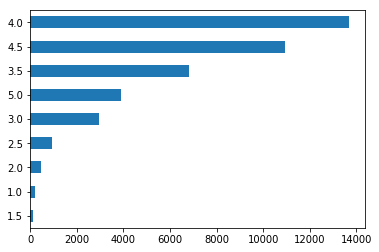

In [144]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

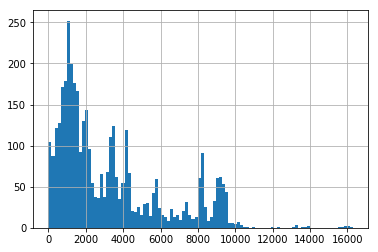

In [145]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

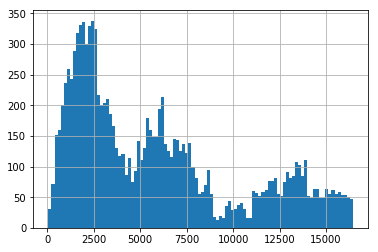

In [146]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков

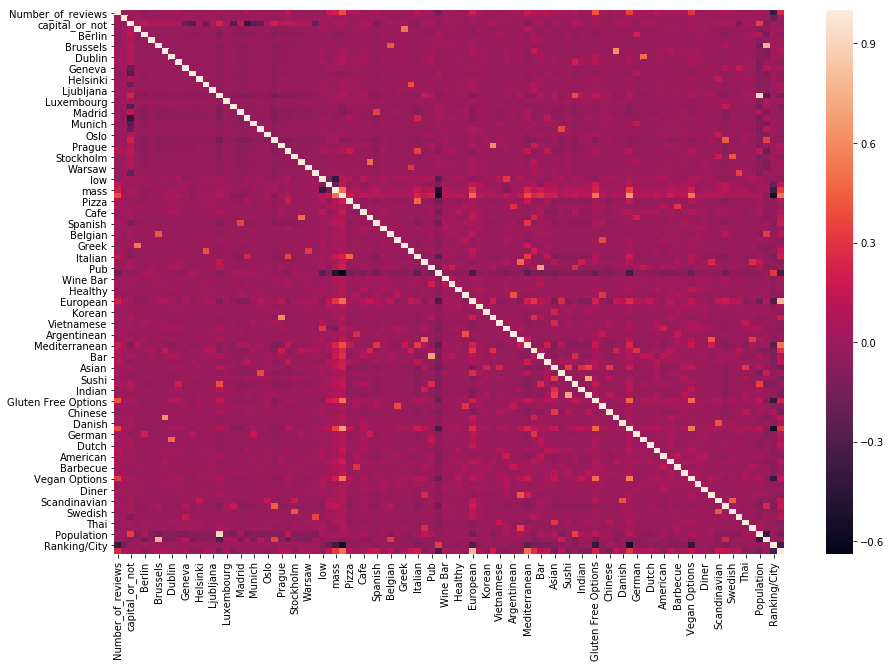

In [147]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [148]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [149]:
data.iloc[8188]['Reviews']

"[['Simple Italian food at reasonable price', 'Good simple Italian food for nice price'], ['01/25/2017', '09/20/2016']]"

In [150]:
import datetime


def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df = df_input.copy()

    # ################### 1. Предобработка ##############################################################

    # переименуем некоторые колонки для удобства
    df = df.rename(columns={'Cuisine Style': 'Cuisine_style', 'Price Range': 'Price_range',
                            'Number of Reviews': 'Number_of_reviews'})

    # удаляем некоторые текстовые столбцы
    df = df.drop(['URL_TA', 'ID_TA'], 1)

    # добавим признак Столица или нет
    noncapital = ['Barcelona', 'Milan', 'Hamburg', 'Munich',
                  'Lyon', 'Oporto', 'Zurich', 'Geneva', 'Krakow']

    df['capital_or_not'] = df.City.apply(lambda x: 0 if x in noncapital else 1)

    # добавляем дамми-переменные по городам
    cityes = pd.get_dummies(df.City, drop_first=True)
    df = pd.concat([df, cityes], sort=False, axis=1)

    # добавляем разбивку по диапазону цен

    df.Price_range = df.Price_range.apply(
        lambda x: 'low' if x == '$' else 'mass' if x == '$$ - $$$' else 'lux' if x == '$$$$' else 0)
    df = pd.concat(
        [df, pd.get_dummies(df.Price_range, drop_first=True)], sort=False, axis=1)
    df = df.drop('Price_range', 1)

    # ################### 2. NAN ##############################################################
    city_number = df.groupby('City')['Number_of_reviews'].mean().reset_index()
    df['Number_of_reviews'] = df.apply(lambda x: x['Number_of_reviews'] if pd.isna(x['Number_of_reviews']) == False
                                       else city_number[city_number['City'] ==
                                                        x['City']]['Number_of_reviews'].iloc[0], axis=1)

    # ################### 3. Feature Engineering ####################################################
    # считаем количество кухонь в каждом рестаране
    df['Cuisine_amount'] = df['Cuisine_style'].str[2:-2].str.split(
        "', '").str.len().fillna(0)

    # чистим столбец типов кухонь
    def clean_name(str_val):
        if pd.isna(str_val):
            return ["Other"]
        str_val = str_val.strip('[]')
        str_val = str_val.strip('""')
        str_val = str_val.replace("\'", '')
        str_val = str_val.split(", ")
        return str_val

    df["Cuisine_style"] = df["Cuisine_style"].apply(clean_name)

    # сделаем дамми-столбцы по кухням, но только по первым 200 популярным

    cuisines = set()
    for i in df['Cuisine_style']:
        for j in i:
            cuisines.add(j)

    cuisines_dct = {}  # создаём пустой словарь для хранения частоты встречи кухонь
    for i in cuisines:  # перебираем список кухонь
        # добавляем в словарь ключ, соответствующий очередной кухне
        cuisines_dct[i] = 0

    for c in df['Cuisine_style']:   # перебираем список кухонь
        for j in c:
            # увеличиваем значение нужного ключа в словаре на 1
            cuisines_dct[j] += 1

    df1 = pd.DataFrame.from_dict(cuisines_dct, columns=[
                                 'Count'], orient='index')
    df1 = df1[df1['Count'] > 200]
    df1.sort_values(by=['Count'], ascending=False)

    def find_item(cell):
        if item in cell:
            return 1
        return 0

    # запускаем код, создающий столбцы с наименованием типа кухни
    for item in df1.index:
        df[item] = df.Cuisine_style.apply(find_item)

    df = df.drop('Cuisine_style', 1)

    # добавим признак "количество ресторанов в городе"
    df['Rests/City'] = df['City'].map(
        df.groupby(['City'])['Restaurant_id'].count().to_dict())

    # добавим популяцию населения в городах
    population = {
        'Paris': 2190327,
        'Stockholm': 961609,
        'London': 8908081,
        'Berlin': 3644826,
        'Munich': 1456039,
        'Oporto': 237591,
        'Milan': 1378689,
        'Bratislava': 432864,
        'Vienna': 1821582,
        'Rome': 4355725,
        'Barcelona': 1620343,
        'Madrid': 3223334,
        'Dublin': 1173179,
        'Brussels': 179277,
        'Zurich': 428737,
        'Warsaw': 1758143,
        'Budapest': 1752286,
        'Copenhagen': 615993,
        'Amsterdam': 857713,
        'Lyon': 506615,
        'Hamburg': 1841179,
        'Lisbon': 505526,
        'Prague': 1301132,
        'Oslo': 673469,
        'Helsinki': 643272,
        'Edinburgh': 488100,
        'Geneva': 200548,
        'Ljubljana': 284355,
        'Athens': 664046,
        'Luxembourg': 115227,
        'Krakow': 769498}

    df['Population'] = df['City'].map(population)
    df['Rests/City/Population'] = df['Rests/City'] / df['Population']
    del df['Rests/City']

    # добавим признак местная ли кухня в ресторане или нет
    european = ['London', 'Paris', 'Berlin',  'Prague',  'Vienna', 'Amsterdam',
                'Brussels', 'Hamburg', 'Munich',  'Budapest', 'Warsaw',
                'Dublin',  'Edinburgh', 'Zurich',  'Geneva', 'Krakow', 'Bratislava', 'Luxembourg', 'Ljubljana']
    mediter = ['Madrid', 'Barcelona', 'Milan',
               'Rome', 'Lyon', 'Athens', 'Oporto', 'Lisbon']
    scandinavian = ['Stockholm', 'Copenhagen',  'Oslo', 'Helsinki']

    def local(x):
        if x in european:
            return 'E'
        elif x in mediter:
            return 'M'
        return 'S'

    df['local_cuisine'] = df.City.apply(local)

    local_cuisine = pd.get_dummies(df.local_cuisine, drop_first=False)
    df = pd.concat([df, local_cuisine], sort=False, axis=1)
    df = df.drop('local_cuisine', 1)

    df['compE'] = df[['European', 'E']].sum(axis=1) > 1
    df['compS'] = df[['Scandinavian', 'S']].sum(axis=1) > 1
    df['compM'] = df[['Mediterranean', 'M']].sum(axis=1) > 1

    def compare(i):
        if i == True:
            return 1
        return 0

    df['local_or_notE'] = df.compE.apply(compare)
    df['local_or_notS'] = df.compS.apply(compare)
    df['local_or_notM'] = df.compM.apply(compare)
    df['local_or_not'] = df[['local_or_notE',
                             'local_or_notS', 'local_or_notM']].sum(axis=1)

    df = df.drop(['E', 'M', 'S', 'local_or_notE', 'local_or_notS',
                  'local_or_notM', 'compE', 'compS', 'compM'], 1)

    # приведем Ranking к единому масштабу
    mean_max = df.groupby('City')['Ranking'].mean().max()
    rank_mean = df.groupby('City')['Ranking'].mean().reset_index()
    rank_mean['Ranking'] = rank_mean['Ranking'].apply(lambda x: mean_max/x)
    df['Ranking'] = df.apply(
        lambda x: x.Ranking*rank_mean[rank_mean.City == x.City].Ranking.iloc[0], axis=1)

    # сделаем параметр о том, сколько ресторанов входит в единую сеть
    # вычислим сетевые рестораны и размер сети
    chain = df['Restaurant_id'].value_counts()
    chain = chain.reset_index()
    chain.columns = ['Restaurant_id', 'chain_count']
    df = df.merge(chain, on='Restaurant_id', how='left')

    # добавим поиск по словам в обзорах
    df.Reviews.fillna(df.Reviews.value_counts().index[0], inplace=True)
    # Параметр review_wordbox включает список слов используемых в Reviews
    df.Reviews = df.Reviews.apply(lambda x: x.lower())
    df['review_wordbox'] = df.Reviews.str.findall(r'\w[a-z]+')

    # Все слова, встречающиеся более 2 раз у ресторанов с целевой переменной от 4.5
    wordbox_positive = pd.Series(
        df[(df['sample'] == 1) & (df.Rating >= 4.5)].review_wordbox.sum())
    p_words = pd.DataFrame(wordbox_positive.value_counts())
    p_words = p_words[p_words[0] > 2]

    # Все слова, встречающиеся более 2 раз у ресторанов с целевой переменной до 3.5
    wordbox_negative = pd.Series(
        df[(df['sample'] == 1) & (df.Rating <= 3.5)].review_wordbox.sum())
    n_words = pd.DataFrame(wordbox_negative.value_counts())
    n_words = n_words[n_words[0] > 2]

    # Слова, уникальные для ресторанов с высоким рейтингом
    positive_review_predictors = []
    for i in p_words.index:
        if i not in list(n_words.index):
            positive_review_predictors.append(i)

    # Слова, уникальные для ресторанов с низким рейтингом
    negative_review_predictors = []
    for i in n_words.index:
        if i not in list(p_words.index):
            negative_review_predictors.append(i)

    # Функция расчитывающая рейтинг по ключевым словам. Нейтральное значение = 0.5
    def valued_review_score(wordbox):
        positives = 1
        negatives = 1
        for i in wordbox:
            if i in positive_review_predictors:
                positives += 1
            elif i in negative_review_predictors:
                negatives += 1
        result = positives/(positives + negatives)
        return result

    df['valued_review'] = df.review_wordbox.apply(valued_review_score)

    # ################### 4. Clean ####################################################

    # убираем не нужные для модели признаки
    df.drop(['Restaurant_id', 'Reviews', 'review_wordbox'], axis=1, inplace=True)
    object_columns = [s for s in df.columns if df[s].dtypes == 'object']
    df.drop(object_columns, axis=1, inplace=True)

    return df

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [151]:
df_preproc = preproc_data(data)
df_preproc.head(50)

,Ranking,Number_of_reviews,sample,Rating,capital_or_not,Athens,Barcelona,Berlin,Bratislava,Brussels,...,French,Swedish,Swiss,Thai,Turkish,Population,Rests/City/Population,local_or_not,chain_count,valued_review
0,15263.103600,4.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,2190327,0.002789,0,16,0.500000
1,1534.811258,97.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,643272,0.000738,1,10,0.500000
2,7476.259365,28.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,488100,0.001526,0,15,0.666667
3,1669.000000,202.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,8908081,0.000807,1,9,0.666667
4,653.677011,162.000000,0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,432864,0.000878,1,14,0.500000
5,5996.681836,24.000000,0,0.0,1,0,0,0,0,0,...,1,0,0,0,0,2190327,0.002789,0,12,0.500000
6,16205.272351,2.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,505526,0.003258,0,9,0.500000
7,15614.811022,158.680214,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1752286,0.000583,0,12,0.500000
8,11163.580000,2.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,643272,0.000738,1,14,0.500000
9,3994.136954,13.000000,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,961609,0.001074,0,13,0.500000


In [152]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 107 entries, Ranking to valued_review
dtypes: float64(6), int64(68), uint8(33)
memory usage: 30.2 MB


In [153]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [154]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [155]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 106), (40000, 106), (40000, 105), (32000, 105), (8000, 105))

# Model 
Сам ML

In [156]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [157]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [158]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [159]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2121325


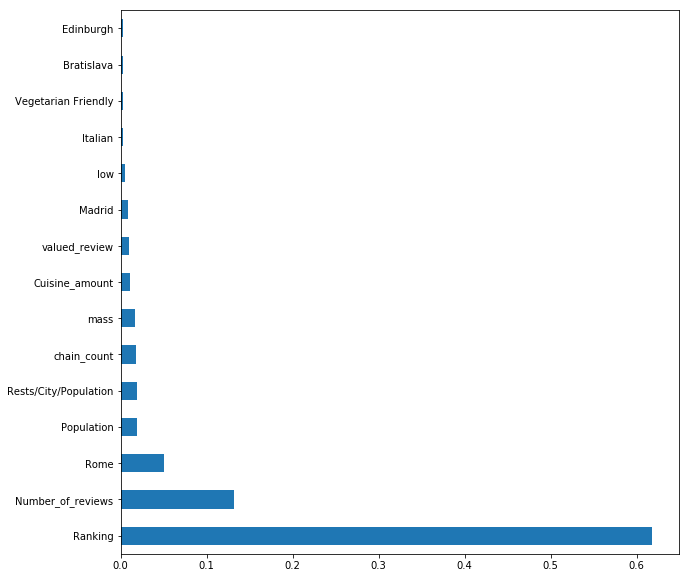

In [160]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [161]:
test_data.sample(10)

,Ranking,Number_of_reviews,Rating,capital_or_not,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,...,French,Swedish,Swiss,Thai,Turkish,Population,Rests/City/Population,local_or_not,chain_count,valued_review
9605,1736.635917,391.000000,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,769498,0.000720,1,2,0.500000
8750,13502.259570,2.000000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,3223334,0.001183,0,3,0.500000
3146,11877.974938,12.000000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,2190327,0.002789,0,4,0.666667
3131,6766.440411,51.616099,0.0,1,0,0,0,1,0,0,...,0,0,0,0,0,432864,0.000878,0,10,0.500000
9230,14852.053285,3.000000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1821582,0.000792,0,1,0.500000
9394,1386.002529,115.000000,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,200548,0.002942,1,1,0.750000
1233,10480.928212,9.000000,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,200548,0.002942,1,10,0.500000
3089,7783.615651,11.000000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,961609,0.001074,0,4,0.500000
9914,15445.015064,3.000000,0.0,1,0,0,0,0,1,0,...,0,0,0,0,0,179277,0.007329,0,1,0.500000
3060,15858.077428,3.000000,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1301132,0.001396,1,6,0.333333


In [162]:
test_data = test_data.drop(['Rating'], axis=1)

In [163]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [164]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [165]:
predict_submission

array([3.26 , 4.185, 4.42 , ..., 3.065, 4.46 , 4.23 ])

In [166]:
adjusted_submission = []
for i in predict_submission:
    if i % 1 >= 0.75:
        adjusted_submission.append(int(i)+1)
    elif 0.75 > i % 1 >= 0.25:
        adjusted_submission.append(int(i)+0.5)
    else:
        adjusted_submission.append(int(i))
predict_submission

array([3.26 , 4.185, 4.42 , ..., 3.065, 4.46 , 4.23 ])

In [167]:
sample_submission['Rating'] = adjusted_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.5
8,id_8,4.5
9,id_9,4.5
